### Import Dependencies


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [5]:
movies = pd.read_csv(r'C:\Users\nguye\Desktop\Movies Recommendation\data\movies.csv')

In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings = pd.read_csv(r'C:\Users\nguye\Desktop\Movies Recommendation\data\ratings.csv')

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Step 3: Exploratory Data Analysis

In [8]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


### What is the distribution of movie ratings?

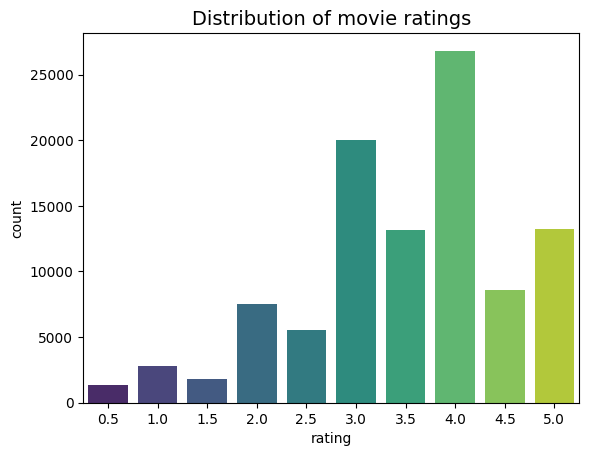

In [9]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [10]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


### Movies are most frequently rated

In [11]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

`Forrest Gump`, `Shawshank Redemption`, and `Pulp Fiction` have the most ratings.

### Lowest and highest rated movies

Which movie has the lowest and highest average rating?

In [8]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


`Gypsy` has the lowest average rating.

In [9]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


 `Lamerica` has only 2 rating, so it reflects the imbalance of number of ratings per movie

In [10]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


### A Glimpse at Movie Genres

The movies dataset needs to be cleaned in two ways:

- `genres` is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- `title` currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

In [17]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**Number of differnece movie genres**

In [18]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [19]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


The top 5 genres are: `Drama`, `Comedy`, `Thriller`, `Action` and `Romance`.

Let's also visualize genres popularity with a barplot.

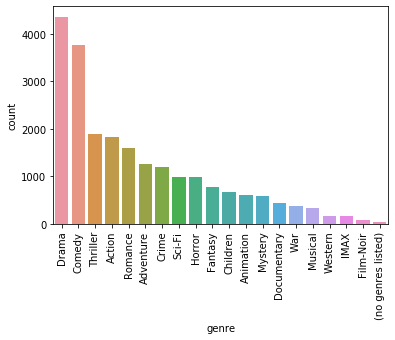

In [20]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

### Data Pre-processing

We are going to use a technique called colaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. 

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations.


The `create_X()` function outputs a sparse matrix $X$ with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our $X$ (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.

In [21]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [22]:
X.shape

(610, 9724)

Our `X` matrix contains 610 users and 9724 movies.

### Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) is equivalent to the number of ratings in our dataset.

In [23]:
n_total = X.shape[0]*X.shape[1] # the operation equal to: 610 * 9724
n_ratings = X.nnz #give number none zero value
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


`csr_matrix.nnz` counts the stored values in our sparse matrix. The rest of our cells are empty.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [24]:
n_ratings_per_user = X.getnnz(axis=1) #axis 1 is row
len(n_ratings_per_user)

610

In [25]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [26]:
n_ratings_per_movie = X.getnnz(axis=0) #axis 0 is column
len(n_ratings_per_movie)

9724

In [27]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


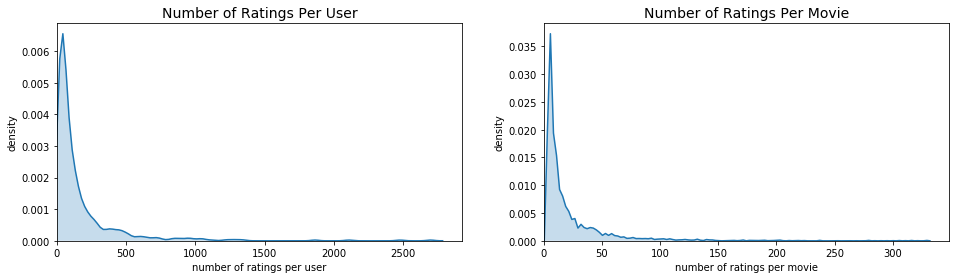

In [28]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1) # create a sublot of 1 row and 2 cols
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

### Item-item Recommendations with k-Nearest Neighbors

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$.

In [29]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [30]:
# test the function
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies # it gives list of ID

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

`find_similar_movies()` returns a list of `movieId`'s that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps `movieId` to `title`.

In [31]:
#create a dictionary that contain ID and title of a movide
movie_titles = dict(zip(movies['movieId'], movies['title']))

# search a movie has an ID of 1
movie_id = 1

# use function find_similar_movies and store it in variable "similar_movies"
similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)

# extract the movie titles and store in variable "movie_title"
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies: # loop over the predicted movie ID and print out its title 
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
